In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

from src.utils import load_all_csv_in_dir

In [13]:
data_dir = os.path.join("..", "PythonAnygrad", "save")
data = load_all_csv_in_dir(data_dir)

In [14]:
data

,strategy,rep,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
0,"Baseline (round robin, m=50)",0,0,Target 1,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,"Baseline (round robin, m=50)",0,0,Target 2,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,"Baseline (round robin, m=50)",0,0,Target 3,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,"Baseline (round robin, m=50)",0,1,Target 1,-1081.805000,50,50,50,5.351363,0.427052,-0.427052,0.008541,NaN,NaN,NaN
4,"Baseline (round robin, m=50)",0,1,Target 2,NaN,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Anygrad (full),0,8,Target 2,-939.730841,100,300,800,43.849126,1.580369,4.950933,0.005268,0.362022,0.000802,0.073125
26,Anygrad (full),0,8,Target 3,-927.821694,100,200,600,32.901835,1.052228,4.935797,0.005261,NaN,NaN,NaN
27,Anygrad (full),0,9,Target 1,-967.180178,100,300,700,38.378631,1.580504,3.146982,0.005268,-0.661530,0.003026,-0.209380
28,Anygrad (full),0,9,Target 2,-939.730841,100,300,800,43.849126,1.580369,4.950933,0.005268,0.362022,0.000802,0.073125


In [15]:
alpha = 0.5

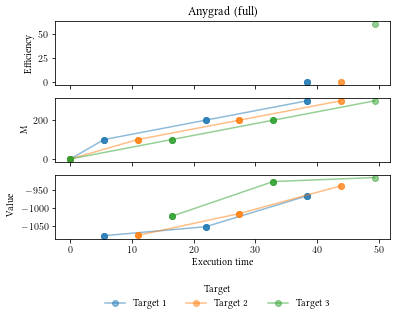

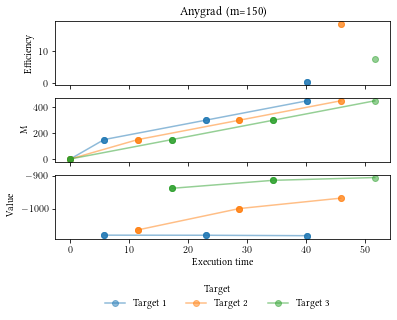

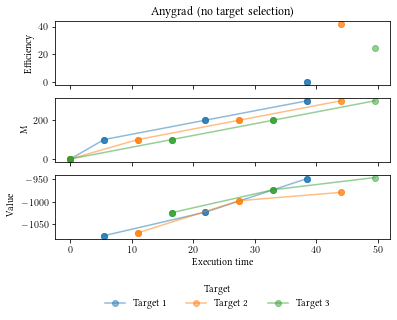

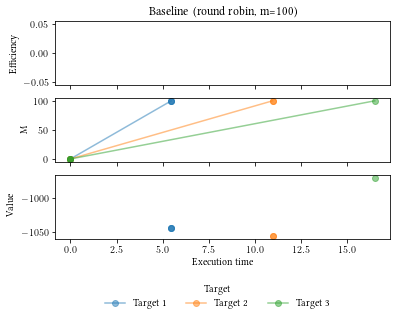

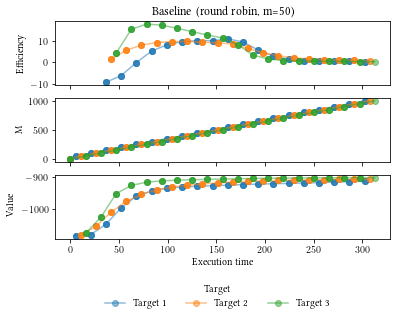

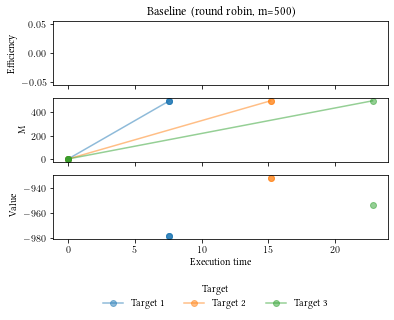

In [16]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    for target in targets:
        target_data = this_data[this_data["target"] == target]
        axes[0].plot(target_data["total_time"], target_data["efficiency"], label=target, alpha=alpha, marker="o")
        axes[1].plot(target_data["total_time"], target_data["M"], label=target, alpha=alpha, marker="o")
        axes[2].plot(target_data["total_time"], target_data["value"], label=target, alpha=alpha, marker="o")
        axes[0].set_title(strategy)
    axes[0].set_ylabel("Efficiency")
    axes[1].set_ylabel("M")
    axes[2].set_ylabel("Value")
    axes[-1].set_xlabel("Execution time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

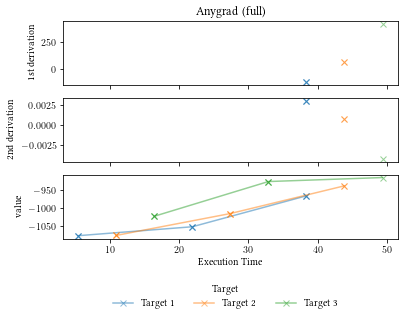

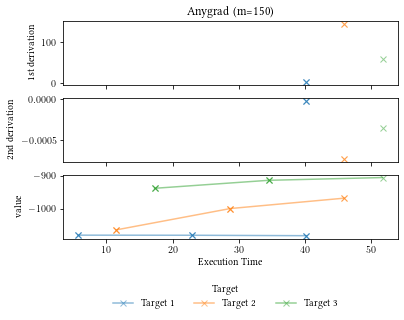

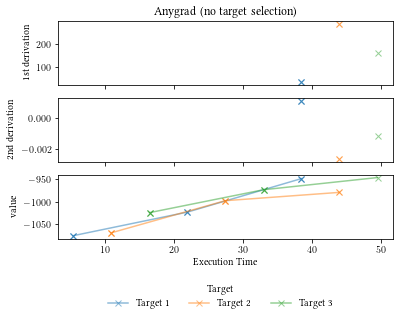

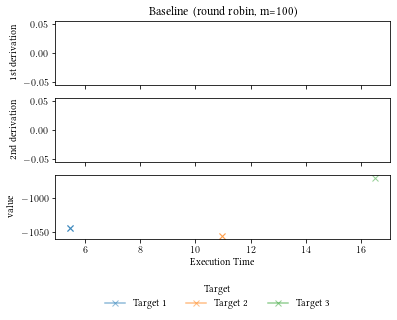

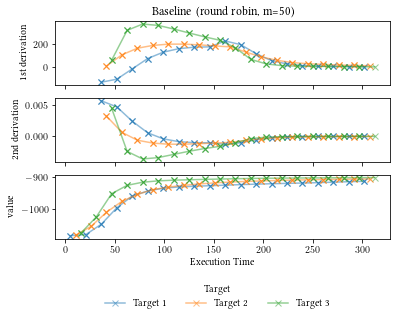

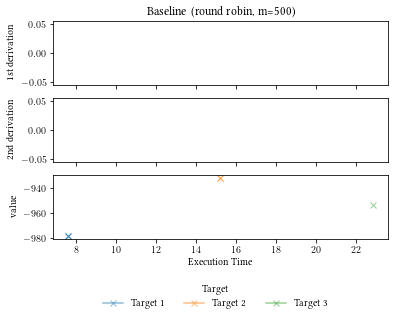

In [17]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    reps = np.unique(this_data["rep"])
    for target in targets:
        for rep in reps:
            target_data = this_data[np.logical_and(this_data["target"] == target, this_data["rep"] == rep)]
            axes[0].plot(target_data["total_time"], target_data["derivation_1st"] / target_data["t1"],
                         label=target, alpha=alpha, marker="x")
            axes[1].plot(target_data["total_time"], target_data["derivation_2nd"],
                         label=target, alpha=alpha, marker="x")
            axes[2].plot(target_data["total_time"], target_data["value"],
                         label=target, alpha=alpha, marker="x")
            axes[0].set_title(strategy)
    axes[0].set_ylabel("1st derivation")
    axes[1].set_ylabel("2nd derivation")
    axes[2].set_ylabel("value")
    axes[-1].set_xlabel("Execution Time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [18]:
def get_auc(x, y):
    y = np.array(y)
    x = np.array(x)
    y = y - np.nanmin(y)
    y = y[np.invert(np.isnan(y))]
    x = x[np.invert(np.isnan(x))]
    return [np.trapz(x=x[:i], y=y[:i]) for i in range(1, len(y), 1)]

def group_df(df: pd.DataFrame):
    df = df.sort_values(by="total_iterations").groupby(by=["strategy", "target"])
    return df

In [19]:
strategies = np.unique(data["strategy"])
df_per_strategy = [data.sort_values(by="total_time")
                       .groupby(by=["strategy"])
                       .get_group(strategy) for strategy in strategies]
df_per_strategy = [df.rolling(window=1).mean() for df in df_per_strategy]

ValueError: x and y must have same first dimension, but have shapes (29,) and (23,)

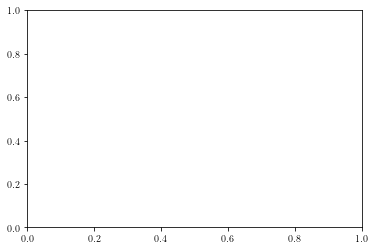

In [20]:
for i, df in enumerate(df_per_strategy):
    x = df["total_time"]
    y = df["value"]
    auc = get_auc(x, y)
    x = x[np.invert(np.isnan(x))]
    plt.plot(x[1:], auc, label=strategies[i])
plt.legend()
plt.show()

In [ ]:

grouped_df = group_df(data)
indices = grouped_df.indices
strategies = np.unique([index[0] for index in indices.keys()])
targets = np.unique([index[1] for index in indices.keys()])

fig, axes = plt.subplots(nrows=len(strategies), ncols=1, sharey="all", sharex="all", figsize=(6,12))
for i, strat in enumerate(strategies):
    for target in targets:
        auc = get_auc(x=grouped_df.get_group((strat, target))["total_time"],
                      y=grouped_df.get_group((strat, target))["value"])
        axes[i].plot(grouped_df.get_group((strat, target))["total_time"][1:],
                     auc,
                     label=target)
    axes[i].set_title(strat)
    axes[i].set_ylabel("Value")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
axes[-1].set_xlabel("Execution time")
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.05, 1, 1),
                    frameon=False, ncol=3, title="Target")
plt.tight_layout()
plt.show()

In [ ]:
y = [-4.39331878, -3.93170969, -3.65555667, -3.45794343, -3.30895812, -3.1925142,
     -3.09831504, -3.02023389, -2.95436115]
x = [3.,  6.,  9., 12., 15., 18., 21., 24., 27.]
coefficients = [-2.54097250e-03, 1.31063455e-01, -4.68765366e+00]

def q_function(x):
    return coefficients[0] * x*x + coefficients[1] * x + coefficients[2]

plt.scatter(x, y, marker="x", label="Measurements")
plt.plot(x, q_function(np.array(x)), label="Fitted curve")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.legend()
plt.show()